# Investigating Eddies using altimetry in Southern Ocean

# Part 1

# Installing required variables

In [ ]:
! pip install xarray numpy matplotlib netcdf4 cartopy pathlib geopandas folium pyarrow ipywidgets ipympl dask scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.0 MB/s eta 0:00:00


In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import folium
from shapely.geometry import Polygon
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.path as mpath
from shapely.ops import transform
import pyproj
from shapely.geometry import shape
from shapely import wkt
import subprocess
import requests
import json
import shutil
import os
import zipfile
import sys
import json
import ipywidgets as widgets
from shapely.geometry import mapping
from IPython.display import display
import matplotlib.lines as mlines

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
week8_path = Path('/content/drive/MyDrive/GEOL0069_AI_for_Earth_Observation/Week8/Notebook/drive-download-20250314T110653Z-001')

# **Selecting Eddies**

## Loading data from Mesoscale Eddy Trajectory

In [ ]:
anticyclonic_gdf = gpd.read_parquet(week8_path / 'anticyclonic_eddies_2019.parquet')
anticyclonic_gdf.head()

track_number       time   longitude   latitude  amplitude  \
0        708928 2019-01-01  151.964188  51.163441     0.0226   
1        708928 2019-01-02  151.962189  51.155045     0.0223   
2        708928 2019-01-03  151.949387  51.167412     0.0217   
3        708928 2019-01-04  152.008545  51.156200     0.0224   
4        708928 2019-01-05  152.002136  51.166542     0.0211   

   effective_height  inner_height  \
0      2.000000e-03         0.024   
1      2.000000e-03         0.024   
2      2.000000e-03         0.022   
3      7.771561e-16         0.022   
4      7.771561e-16         0.020   

                                            geometry  
0  POLYGON ((151.88 50.84, 152.12 50.81, 152.38 5...  
1  POLYGON ((152.12 50.84, 152.38 50.87, 152.44 5...  
2  POLYGON ((152.12 50.86, 152.27 50.88, 152.38 5...  
3  POLYGON ((152.38 50.85, 152.49 50.88, 152.42 5...  
4  POLYGON ((152.38 50.87, 152.4 50.88, 152.41 51...

In [ ]:
cyclonic_gdf = gpd.read_parquet(week8_path / 'cyclonic_eddies_2019.parquet')
cyclonic_gdf.head()

track_number       time  longitude   latitude  amplitude  effective_height  \
0        713905 2019-01-01  99.719543 -40.455067     0.2246      7.771561e-16   
1        713905 2019-01-02  99.691483 -40.453773     0.2298      2.000000e-03   
2        713905 2019-01-03  99.656265 -40.448448     0.2341      2.000000e-03   
3        713905 2019-01-04  99.623764 -40.443928     0.2375      4.000000e-03   
4        713905 2019-01-05  99.594589 -40.442413     0.2379      4.000000e-03   

   inner_height                                           geometry  
0        -0.224  POLYGON ((98.82 -41.12, 98.65 -40.88, 98.54 -4...  
1        -0.226  POLYGON ((98.88 -41.2, 98.74 -41.12, 98.5 -40....  
2        -0.232  POLYGON ((98.7 -41.12, 98.62 -40.87, 98.5 -40....  
3        -0.232  POLYGON ((98.64 -41.12, 98.58 -40.88, 98.47 -4...  
4        -0.232  POLYGON ((98.66 -41.12, 98.47 -40.62, 98.49 -4...

In [ ]:
southern_cyclonic_gdf = cyclonic_gdf.cx[0:360, -80:-60].copy()
southern_anticyclonic_gdf = anticyclonic_gdf.cx[0:360, -80:-60].copy()

## Displaying eddy in southern ocean

<ipython-input-8-622f73a750d7>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


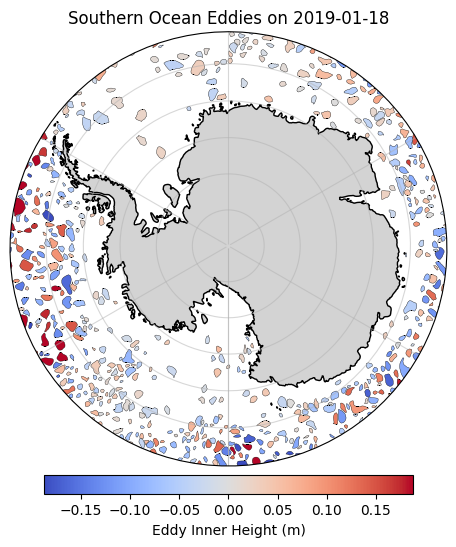

In [ ]:
%matplotlib inline

#Select date
selected_time = "2019-01-18"

# Plot the eddies on a global map for a single day
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection':ccrs.SouthPolarStereo()})
ax.set_extent([-180, 180, -80,-60], crs=ccrs.PlateCarree())

# Add features
ax.coastlines()
ax.add_feature(cfeature.LAND, color='lightgray')
ax.gridlines(alpha=0.5)

# Get colorscales for inner height
min_mins = min(southern_anticyclonic_gdf[southern_anticyclonic_gdf["time"] == selected_time]["inner_height"].min(), southern_cyclonic_gdf[southern_cyclonic_gdf["time"] == selected_time]["inner_height"].min())
max_maxs = max(southern_anticyclonic_gdf[southern_anticyclonic_gdf["time"] == selected_time]["inner_height"].max(), southern_cyclonic_gdf[southern_cyclonic_gdf["time"] == selected_time]["inner_height"].max())
quartile_mins = min(np.quantile(southern_anticyclonic_gdf[southern_anticyclonic_gdf["time"] == selected_time]["inner_height"], 0.05), np.quantile(southern_cyclonic_gdf[southern_cyclonic_gdf["time"] == selected_time]["inner_height"], 0.05))
quartile_maxs = max(np.quantile(southern_anticyclonic_gdf[southern_anticyclonic_gdf["time"] == selected_time]["inner_height"], 0.95), np.quantile(southern_cyclonic_gdf[southern_cyclonic_gdf["time"] == selected_time]["inner_height"], 0.95))
cmap_bound = max(abs(quartile_mins), abs(quartile_maxs))


norm = mcolors.Normalize(vmin=-cmap_bound, vmax=cmap_bound)
cmap = cm.get_cmap('coolwarm')

for _, row in southern_anticyclonic_gdf[southern_anticyclonic_gdf["time"] == selected_time].iterrows():
    color = cmap(norm(row["inner_height"]))
    ax.add_geometries(
        [row.geometry], crs=ccrs.PlateCarree(),
        facecolor=color, edgecolor="black", linewidth=0.25,
    )

for _, row in southern_cyclonic_gdf[southern_cyclonic_gdf["time"] == selected_time].iterrows():
    color = cmap(norm(row["inner_height"]))
    ax.add_geometries(
        [row.geometry], crs=ccrs.PlateCarree(),
        facecolor=color, edgecolor="black", linewidth=0.25,
    )

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.04, pad=0.02)
cbar.set_label("Eddy Inner Height (m)")

# Make the axis round
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

plt.title(f"Southern Ocean Eddies on {selected_time}")
plt.show()


## Method 1 of selecting eddy

<ipython-input-9-141b597ef3ab>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_area = cm.get_cmap('tab10')
<ipython-input-9-141b597ef3ab>:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_height = cm.get_cmap('tab10')


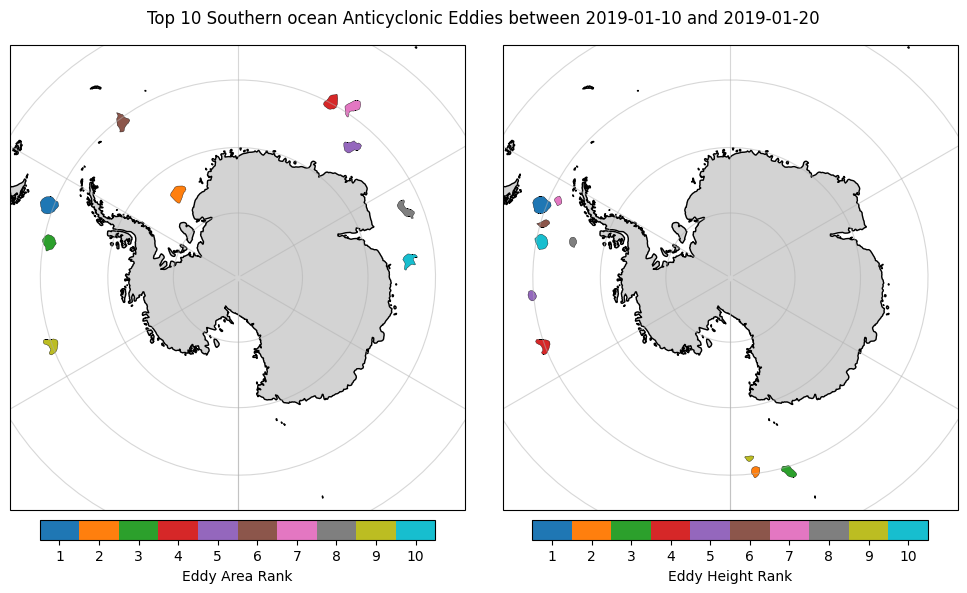

In [ ]:
#Let's find an interesting anticyclonic eddy based on the time, inner height and/or effective_area

# Find the area of the eddies inside the 'effective contour' (notice we must reproject the geometries to get a more accurate area)
southern_anticyclonic_gdf["effective_area"]  = southern_anticyclonic_gdf["geometry"].to_crs("EPSG:6932").area

#select the date range
start_date = pd.to_datetime("2019-01-10")
end_date = pd.to_datetime("2019-01-20")

southern_anticyclonic_gdf_filtered = southern_anticyclonic_gdf[(southern_anticyclonic_gdf["time"] >= start_date) & (southern_anticyclonic_gdf["time"] <= end_date)]

# Let's find the 'big' eddies for possible selection
biggest_areas = southern_anticyclonic_gdf_filtered.loc[southern_anticyclonic_gdf_filtered.groupby('track_number')['effective_area'].idxmax()].nlargest(10, "effective_area")
large_heights = southern_anticyclonic_gdf_filtered.loc[southern_anticyclonic_gdf_filtered.groupby('track_number')['inner_height'].idxmax()].nlargest(10, "inner_height")

#plot them
%matplotlib inline

# Plot the anticyclonic eddies with the top 10 effective areas and color them by their order
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection':ccrs.SouthPolarStereo()})
ax1.set_extent([-180, 180, -80, -55], crs=ccrs.PlateCarree())
ax1.coastlines()
ax1.add_feature(cfeature.LAND, color='lightgray')
ax1.gridlines(alpha=0.5)

# Color by order for effective area
norm_area = mcolors.Normalize(vmin=0, vmax=10)
cmap_area = cm.get_cmap('tab10')

for i, (_, row) in enumerate(biggest_areas.iterrows()):
    color = cmap_area(norm_area(i))
    ax1.add_geometries(
        [row.geometry], crs=ccrs.PlateCarree(),
        facecolor=color, edgecolor="black", linewidth=0.25,
    )

# Add colorbar for effective area
sm_area = cm.ScalarMappable(cmap=cmap_area, norm=norm_area)
sm_area.set_array([])
cbar_area = plt.colorbar(sm_area, ax=ax1, orientation="horizontal", fraction=0.04, pad=0.02)
cbar_area.set_label("Eddy Area Rank")

# Improve colorbar tick labels for effective area
cbar_area.set_ticks(np.linspace(0.5, 9.5, 10))
cbar_area.set_ticklabels([f"{i+1}" for i in range(10)])

# Plot the anticyclonic eddies with the top 10 effective heights and color them by their order
ax2.set_extent([-180, 180, -80, -55], crs=ccrs.PlateCarree())
ax2.coastlines()
ax2.add_feature(cfeature.LAND, color='lightgray')
ax2.gridlines(alpha=0.5)

# Color by order for effective height
norm_height = mcolors.Normalize(vmin=0, vmax=10)
cmap_height = cm.get_cmap('tab10')

for i, (_, row) in enumerate(large_heights.iterrows()):
    color = cmap_height(norm_height(i))
    ax2.add_geometries(
        [row.geometry], crs=ccrs.PlateCarree(),
        facecolor=color, edgecolor="black", linewidth=0.25,
    )

# Add colorbar for effective height
sm_height = cm.ScalarMappable(cmap=cmap_height, norm=norm_height)
sm_height.set_array([])
cbar_height = plt.colorbar(sm_height, ax=ax2, orientation="horizontal", fraction=0.04, pad=0.02)
cbar_height.set_label("Eddy Height Rank")

# Improve colorbar tick labels for effective height
cbar_height.set_ticks(np.linspace(0.5, 9.5, 10))
cbar_height.set_ticklabels([f"{i+1}" for i in range(10)])

plt.suptitle(f"Top 10 Southern ocean Anticyclonic Eddies between {start_date.date()} and {end_date.date()}")
plt.tight_layout()
plt.show()

In [ ]:
biggest_areas

track_number       time   longitude   latitude  amplitude  \
137485        719595 2019-01-18  291.006683 -59.151901     0.4463   
129435        719364 2019-01-11  324.710785 -73.969955     0.0208   
167434        720257 2019-01-19  280.921783 -60.759865     0.2809   
128288        719330 2019-01-20   28.038132 -59.758148     0.1856   
174419        720402 2019-01-13   40.681793 -63.527271     0.0497   
3784          709950 2019-01-19  322.921082 -60.252327     0.0720   
67934         716731 2019-01-16   33.800308 -58.630341     0.1997   
124376        719220 2019-01-11   66.183006 -62.744446     0.1052   
166994        720250 2019-01-20  250.308838 -60.066448     0.2829   
112717        718922 2019-01-16   83.770218 -63.909851     0.0575   

        effective_height  inner_height  \
137485     -2.800000e-02         0.418   
129435      6.000000e-03         0.026   
167434     -3.800000e-02         0.242   
128288     -6.000000e-03         0.178   
174419     -1.200000e-02         0.036   
3784        7.771561e-16         0.072   
67934       4.000000e-03         0.202   
124376      2.000000e-02         0.124   
166994      1.000000e-02         0.292   
112717      3.400000e-02         0.090   

                                                 geometry  effective_area  
137485  POLYGON ((291.12 -60.47, 291.88 -60.57, 292.88...    6.076847e+10  
129435  POLYGON ((321.88 -75.29, 322.62 -75.23, 324.88...    4.838523e+10  
167434  POLYGON ((280.38 -61.73, 280.88 -61.77, 281.2 ...    3.940498e+10  
128288  POLYGON ((26.62 -60.77, 27.62 -60.86, 28.12 -6...    3.907072e+10  
174419  POLYGON ((39.88 -64.63, 41.12 -64.61, 41.62 -6...    3.872927e+10  
3784    POLYGON ((322.12 -61.65, 322.72 -61.38, 323.38...    3.793886e+10  
67934   POLYGON ((33.62 -60.4, 34.12 -60.45, 34.28 -60...    3.789882e+10  
124376  POLYGON ((66.38 -63.38, 68.12 -63.07, 69.46 -6...    3.734672e+10  
166994  POLYGON ((250.62 -60.91, 251.12 -60.85, 251.57...    3.602558e+10  
112717  POLYGON ((83.62 -64.72, 84.62 -64.49, 85.12 -6...    3.476751e+10

In [ ]:
large_heights

track_number       time   longitude   latitude  amplitude  \
137486        719595 2019-01-19  291.028870 -59.159595     0.4420   
116640        719035 2019-01-20  172.708206 -60.371971     0.2091   
56093         716004 2019-01-10  163.365967 -59.413330     0.2705   
166991        720250 2019-01-17  250.369339 -59.979000     0.2767   
113516        718942 2019-01-10  264.862091 -59.758423     0.1578   
106764        718703 2019-01-19  286.356384 -60.505680     0.1420   
98689         718408 2019-01-19  294.085754 -61.216591     0.1840   
8751          711044 2019-01-10  282.933563 -65.177498     0.2424   
80535         717579 2019-01-14  174.094543 -62.430714     0.1476   
167431        720257 2019-01-16  280.960144 -60.737171     0.2853   

        effective_height  inner_height  \
137486            -0.022         0.420   
116640             0.158         0.366   
56093              0.034         0.304   
166991             0.022         0.298   
113516             0.134         0.290   
106764             0.130         0.272   
98689              0.082         0.266   
8751               0.010         0.252   
80535              0.100         0.246   
167431            -0.040         0.244   

                                                 geometry  effective_area  
137486  POLYGON ((291.12 -60.47, 291.88 -60.56, 292.62...    5.977068e+10  
116640  POLYGON ((171.62 -60.91, 172.12 -61.04, 172.38...    1.822989e+10  
56093   POLYGON ((162.88 -60.2, 163.88 -60.26, 164.38 ...    2.809880e+10  
166991  POLYGON ((249.88 -60.73, 250.62 -60.81, 251.22...    3.270467e+10  
113516  POLYGON ((264.12 -60.23, 264.62 -60.34, 264.88...    1.679043e+10  
106764  POLYGON ((286.62 -61.19, 286.88 -61.2, 287.12 ...    1.577986e+10  
98689   POLYGON ((293.62 -61.8, 293.88 -61.81, 294.12 ...    1.273247e+10  
8751    POLYGON ((281.88 -65.64, 282.62 -65.77, 282.88...    1.478993e+10  
80535   POLYGON ((172.88 -62.66, 173.38 -62.71, 173.62...    9.128586e+09  
167431  POLYGON ((280.62 -61.68, 281.62 -61.52, 282.38...    3.778596e+10

Justification of selecting the eddy: The biggest eddy that is located near the Weddell Sea was chosen to understand SSHA change near weddell sea.

In [ ]:

selected_eddy = southern_anticyclonic_gdf_filtered.loc[biggest_areas.index[2-1]]
selected_eddy

track_number                                                   719364
time                                              2019-01-11 00:00:00
longitude                                                  324.710785
latitude                                                   -73.969955
amplitude                                                      0.0208
effective_height                                                0.006
inner_height                                                    0.026
geometry            POLYGON ((321.88 -75.29, 322.62 -75.23, 324.88...
effective_area                                     48385228910.517166
Name: 129435, dtype: object

# Interactive data loading Option 2

In [ ]:
# Calculate the effective area of the eddies
southern_cyclonic_gdf["effective_area"] = southern_cyclonic_gdf["geometry"].to_crs("EPSG:6932").area
southern_anticyclonic_gdf["effective_area"] = southern_anticyclonic_gdf["geometry"].to_crs("EPSG:6932").area

#convert the area to km^2
southern_cyclonic_gdf["effective_area"] = southern_cyclonic_gdf["effective_area"] / 1e6
southern_anticyclonic_gdf["effective_area"] = southern_anticyclonic_gdf["effective_area"] / 1e6

# Ensure CRS is WGS84 (EPSG:4326)
southern_cyclonic_gdf = southern_cyclonic_gdf.to_crs(epsg=4326)
southern_anticyclonic_gdf = southern_anticyclonic_gdf.to_crs(epsg=4326)

#Add whether cyclonic or anticyclonic
southern_cyclonic_gdf["type"] = "Cyclonic"
southern_anticyclonic_gdf["type"] = "Anticyclonic"

# Get available dates
available_dates = sorted(southern_cyclonic_gdf["time"].dt.date.unique())

# Function to convert GeoDataFrame to GeoJSON
def gdf_to_geojson(gdf):
    features = []
    for _, row in gdf.iterrows():
        feature = {
            "type": "Feature",
            "geometry": mapping(row.geometry),
            "properties": {
                "Eddie Type": row["type"],
                "Track Number": row["track_number"],
                "Time": row["time"].strftime("%Y-%m-%d"),
                "Latitude": row.geometry.centroid.y,
                "Longitude": row.geometry.centroid.x,
                "Area": row["effective_area"],
                "Inner Height": row["inner_height"],
            },
        }
        features.append(feature)
    return json.dumps({"type": "FeatureCollection", "features": features})

# Function to create Folium map for a selected date
def create_folium_map(selected_date):
    selected_date = pd.to_datetime(selected_date)

    # Filter eddies for this date
    cyclonic_filtered = southern_cyclonic_gdf[southern_cyclonic_gdf["time"].dt.date == selected_date.date()]
    anticyclonic_filtered = southern_anticyclonic_gdf[southern_anticyclonic_gdf["time"].dt.date == selected_date.date()]

    print(f"Date: {selected_date}, Cyclonic: {len(cyclonic_filtered)}, Anticyclonic: {len(anticyclonic_filtered)}")

    # Create the map
    m = folium.Map(location=[0, 180], zoom_start=2, tiles="OpenStreetMap")

    # Add Cyclonic Eddies (red)
    if not cyclonic_filtered.empty:
        folium.GeoJson(
            gdf_to_geojson(cyclonic_filtered),
            name="Cyclonic Eddies",
            popup=folium.GeoJsonPopup(fields=["Eddie Type", "Track Number", "Time", "Latitude", "Longitude", "Area", "Inner Height"],
                                      aliases=["Eddie Type", "Track Number:", "Date:", "Lat:", "Lon:", "Area (m^2):", "Inner Height (m):"]),
            tooltip=folium.GeoJsonTooltip(fields=["Eddie Type", "Time", "Latitude", "Longitude", "Area", "Inner Height"],
                                          aliases=["Eddie Type:", "Date:", "Lat:", "Lon:", "Area (km^2):", "Inner Height (m):"]),
            color = "blue"
        ).add_to(m)

    # Add Anticyclonic Eddies (blue)
    if not anticyclonic_filtered.empty:
        folium.GeoJson(
            gdf_to_geojson(anticyclonic_filtered),
            name="Anticyclonic Eddies",
            popup=folium.GeoJsonPopup(fields=["Eddie Type", "Track Number", "Time", "Latitude", "Longitude", "Area", "Inner Height"],
                                      aliases=["Eddie Type", "Track Number:", "Date:", "Lat:", "Lon:", "Area (m^2):", "Inner Height (m):"]),
            tooltip=folium.GeoJsonTooltip(fields=["Eddie Type", "Time", "Latitude", "Longitude", "Area", "Inner Height"],
                                          aliases=["Eddie Type:", "Date:", "Lat:", "Lon:", "Area (km^2):", "Inner Height (m):"]),
            color = "red"
        ).add_to(m)

    # Add Layer Control
    folium.LayerControl().add_to(m)

    return m

# Create interactive date slider
date_slider = widgets.SelectionSlider(
    options=available_dates,
    description="Date",
    continuous_update=True,
    orientation="horizontal",
    layout=widgets.Layout(width="800px")
)

# Output widget to display the map
output = widgets.Output()

# Function to update map when slider is changed
def update_map(change):
    with output:
        output.clear_output(wait=True)  # Clear previous map before rendering a new one
        display(create_folium_map(change.new))

# Observe slider changes
date_slider.observe(update_map, names="value")

# Arrange widgets
ui = widgets.VBox([date_slider, output])

# Display UI
display(ui)

# Show initial map
with output:
    display(create_folium_map(available_dates[0]))


In [ ]:
#Having navigated to 2019-01-18, I found the same eddy I was interested in exploring in option 1
#After clicking on it, I see the following information:

eddie_type = "Anticyclonic"
selected_date = "2019-01-13"
selected_track_number = 719364

#I can now use this information to obtain the eddy's data from the dataset
selected_eddy = southern_anticyclonic_gdf[(southern_anticyclonic_gdf["time"].dt.date == pd.to_datetime(selected_date).date()) \
    & (southern_anticyclonic_gdf["track_number"] == selected_track_number)].iloc[0]

selected_eddy


track_number                                                   719364
time                                              2019-01-13 00:00:00
longitude                                                  324.375153
latitude                                                   -74.003647
amplitude                                                      0.0183
effective_height                                                 0.01
inner_height                                                    0.028
geometry            POLYGON ((322.62 -75.15, 324.88 -74.86, 326.01...
effective_area                                           32040.222485
type                                                     Anticyclonic
Name: 129437, dtype: object

This shows it's possible to get the same eddy with both methods

# Conversion and selection of eddies


In [ ]:
# The eddy coords use the 0–360 longitude convention.
# Let's change them to -180 to 180 for true consistency with the EPSG:4326 projection
# before we save the eddy and continue our search for data.

from shapely.geometry import Polygon

# Function to shift longitudes from 0–360 to -180–180
def shift_longitude(geometry):
    if geometry.geom_type == "Polygon":
        new_coords = [((lon - 360 if lon > 180 else lon), lat) for lon, lat in geometry.exterior.coords]
        return Polygon(new_coords)
    elif geometry.geom_type == "MultiPolygon":
        new_polygons = []
        for poly in geometry.geoms:
            new_coords = [((lon - 360 if lon > 180 else lon), lat) for lon, lat in poly.exterior.coords]
            new_polygons.append(Polygon(new_coords))
        return gpd.GeoSeries(new_polygons).unary_union
    return geometry

# Store the eddy in a GeoDataFrame
selected_eddy_gdf = gpd.GeoDataFrame([selected_eddy])

# Apply our algorithm to correct the longitude convention
selected_eddy_gdf['geometry'] = selected_eddy_gdf['geometry'].apply(shift_longitude)

# Set the CRS of the GeoDataFrame
selected_eddy_gdf = selected_eddy_gdf.set_crs('EPSG:4326')

# Let's save the selected eddy's data to a GeoPackage
selected_eddy_gdf.to_file(
    week8_path / f"selected_eddy_{selected_eddy['time'].strftime('%Y-%m-%d')}_{selected_eddy['track_number']}.gpkg",
    layer='row',
    driver='GPKG'
)

# Retrieve the amended eddy polygon for further processing
selected_eddy = selected_eddy_gdf.iloc[0]



/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


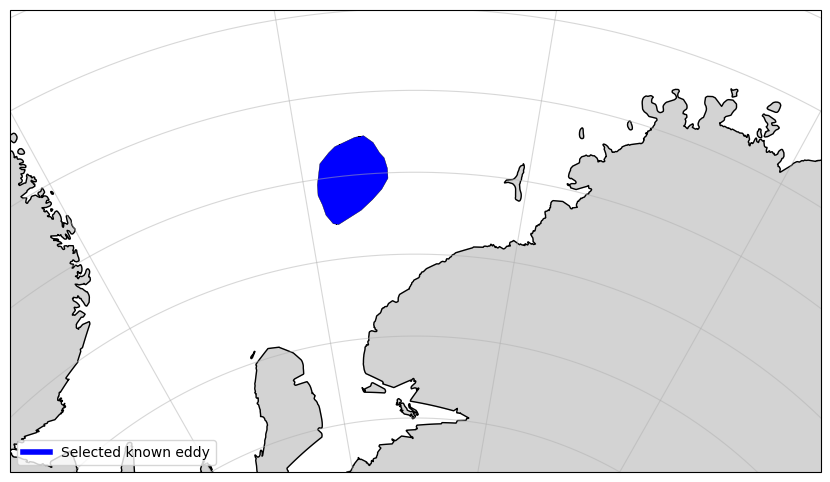

In [ ]:
#plot the eddy just to confirm
%matplotlib inline

fig, ax = plt.subplots(figsize=(13, 6), subplot_kw={'projection':ccrs.TransverseMercator(central_longitude=330)})
ax.set_extent([300, 360, -80, -70], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND, color='lightgray')
ax.gridlines(alpha=0.5)

# Plot the selected eddy
ax.add_geometries(
    [selected_eddy['geometry']], crs=ccrs.PlateCarree(),
    facecolor="blue", edgecolor="black", linewidth=0.25,
)

# Add a legend
eddy_proxy = mlines.Line2D([], [], color='blue', linewidth=4, label="Selected known eddy")
ax.legend(handles=[eddy_proxy], loc='lower left')

plt.show()


In [ ]:
selected_eddy_gdf = gpd.GeoDataFrame([selected_eddy])
selected_eddy_gdf.to_file(week8_path / f"selected_eddy_{selected_eddy['time'].strftime('%Y-%m-%d')}_{selected_eddy['track_number']}.gpkg", layer='row', driver='GPKG')


/usr/local/lib/python3.11/dist-packages/pyogrio/geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


# Downloading the altimetry data from Sentinel 3


In [ ]:
def get_access_token(username, password):
    """
    Obtain an access token to the Copernicus Data Space Ecosystem.
    Necessary for the download of hosted products.
    """
    p =  subprocess.run(f"curl --location --request POST 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' \
            --header 'Content-Type: application/x-www-form-urlencoded' \
            --data-urlencode 'grant_type=password' \
            --data-urlencode 'username={username}' \
            --data-urlencode 'password={password}' \
            --data-urlencode 'client_id=cdse-public'", shell=True,capture_output=True, text=True)
    access_dict = json.loads(p.stdout)
    return access_dict['access_token'], access_dict['refresh_token']

#=============================================================================================================================================================#

def get_new_access_token(refresh_token):
    """
    Obtain a new access token to the Copernicus Data Space Ecosystem using a previously provided refesh token.
    """
    p =  subprocess.run(f"curl --location --request POST 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' \
    --header 'Content-Type: application/x-www-form-urlencoded' \
    --data-urlencode 'grant_type=refresh_token' \
    --data-urlencode 'refresh_token={refresh_token}' \
    --data-urlencode 'client_id=cdse-public'", shell=True,capture_output=True, text=True)
    access_dict = json.loads(p.stdout)
    return access_dict['access_token'], access_dict['refresh_token']

#=============================================================================================================================================================#

def get_S3_SI_search_results_df(date):

    """
    Obtain a pandas dataframe of Sentinel-3 sea ice thematic products for a given date.
    """

    json = requests.get(f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name eq 'SENTINEL-3' \
                        and Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'productType' and att/OData.CSC.StringAttribute/Value eq 'SR_2_LAN_SI') \
                        and Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'timeliness' and att/OData.CSC.StringAttribute/Value eq 'NT') \
                        and ContentDate/Start gt {(date-pd.Timedelta(days=1)).strftime('%Y-%m-%dT%H:%M:%SZ')} \
                        and ContentDate/End lt {(date+pd.Timedelta(days=2)).strftime('%Y-%m-%dT%H:%M:%SZ')}&$top=1000").json()

    results_df = pd.DataFrame.from_dict(json['value'])
    results_df['Satellite'] = [row['Name'][:3] for i,row in results_df.iterrows()]
    results_df['SensingStart'] = [pd.to_datetime(row['ContentDate']['Start']) for i,row in results_df.iterrows()]
    results_df['SensingEnd'] = [pd.to_datetime(row['ContentDate']['End']) for i,row in results_df.iterrows()]
    results_df = results_df[(results_df['SensingEnd'] >= date) & (results_df['SensingStart'] <= date+pd.Timedelta(days=1))]
    results_df['Cycle'] = [row['Name'][-30:-27] for i,row in results_df.iterrows()]
    results_df = results_df.sort_values(by='SensingStart')
    return results_df


#=============================================================================================================================================================#

def unzip_download(zip_path, save_loc, remove_zip_after_dl=True):
    print(f"Unpacking {zip_path.split('/')[-1]}")
    shutil.unpack_archive(zip_path, save_loc, 'zip')

    # print(f"{zip_path.split('/')[-1]} file unpacked successfully.")
    if  remove_zip_after_dl == True:
        os.remove(zip_path)

#=============================================================================================================================================================#

def is_zipfile_valid(file_path):
    try:
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            # Check if the ZIP file is valid without extracting its contents
            return zip_ref.testzip() is None
    except zipfile.BadZipFile:
        return False

#=============================================================================================================================================================#


def download_single_product(
    product_id, file_name, access_token, download_dir="downloaded_products"
):
    """
    Download a single product from the Copernicus Data Space.

    :param product_id: The unique identifier for the product.
    :param file_name: The name of the file to be downloaded.
    :param access_token: The access token for authorization.
    :param download_dir: The directory where the product will be saved.
    """
    # Ensure the download directory exists
    os.makedirs(download_dir, exist_ok=True)

    # Construct the download URL
    url = (
        f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"
    )

    # Set up the session and headers
    headers = {"Authorization": f"Bearer {access_token}"}
    session = requests.Session()
    session.headers.update(headers)

    # Perform the request
    response = session.get(url, headers=headers, stream=True)

    # Check if the request was successful
    if response.status_code == 200:
        # Define the path for the output file
        output_file_path = os.path.join(download_dir, file_name + ".zip")

        # Stream the content to a file
        with open(output_file_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
        print(f"Downloaded: {output_file_path}")
    else:
        print(
            f"Failed to download product {product_id}. Status Code: {response.status_code}"
        )

#=============================================================================================================================================================#

def download_S3_from_df(results_df_row, token, target_dir, rm_zip=True):
    """
    Download the S3 sea ice thematic corrosponding to a given row in a generated Copernicus Data Space Ecosystem search results dataframe.
    S3 sea ice thematic files automatically are stored in the appropriate CPOM server directory.
    """
    os.makedirs(target_dir, exist_ok=True)
    zip_save_name = results_df_row['Name'][:-5]+'.zip'
    zip_path = os.path.join(target_dir,zip_save_name)

    # Check we haven't already downloaded + extracted the files
    if (os.path.exists(os.path.join(target_dir,results_df_row['Name'],'enhanced_measurement.nc')) == False) or (os.path.exists(os.path.join(target_dir,results_df_row['Name'],'standard_measurement.nc')) == False):

        print(f"Downloading {results_df_row['Name'][:-5]}")
        # Download the desired product
        downloaded_zip_valid = False
        while downloaded_zip_valid == False:
            # download_product(results_df_row['Id'], zip_path, token, )
            download_single_product(results_df_row['Id'], results_df_row['Name'][:-5], token, target_dir)
            downloaded_zip_valid = is_zipfile_valid(zip_path)
        unzip_download(zip_path, target_dir, rm_zip)




In [ ]:
date = selected_eddy['time']
date_window = pd.Timedelta(days=7)
dates = pd.date_range(date-date_window, date+date_window, freq='D')

#Query the Copernicus Data Space Ecosystem for Sentinel-3 sea ice thematic products for the given date range
search_results = []
for date in dates:
    print(f'Querying for {date}')
    date = date.tz_localize('UTC')
    search_results.append(get_S3_SI_search_results_df(date))

search_results_df = pd.concat(search_results)
print(f'Found {len(search_results_df)} products')

Querying for 2019-01-06 00:00:00
Querying for 2019-01-07 00:00:00
Querying for 2019-01-08 00:00:00
Querying for 2019-01-09 00:00:00
Querying for 2019-01-10 00:00:00
Querying for 2019-01-11 00:00:00
Querying for 2019-01-12 00:00:00
Querying for 2019-01-13 00:00:00
Querying for 2019-01-14 00:00:00
Querying for 2019-01-15 00:00:00
Querying for 2019-01-16 00:00:00
Querying for 2019-01-17 00:00:00
Querying for 2019-01-18 00:00:00
Querying for 2019-01-19 00:00:00
Querying for 2019-01-20 00:00:00
Found 867 products


In [ ]:
search_results_df.head()

@odata.mediaContentType                                    Id  \
55  application/octet-stream  5835f303-8908-34eb-9e5b-56d32bcb8907   
56  application/octet-stream  26d7fc38-6c8f-3cf7-b16a-9bc0b1beea33   
57  application/octet-stream  7fe843f4-40e8-3041-b4a6-d2b1c51d549d   
58  application/octet-stream  e310b8f6-6f67-3631-a4d1-adfd80a686ea   
59  application/octet-stream  7aab0c4a-b9ad-343e-8007-10e921f4da5e   

                                                 Name  \
55  S3A_SR_2_LAN_SI_20190106T001420_20190106T00391...   
56  S3B_SR_2_LAN_SI_20190106T002846_20190106T00473...   
57  S3A_SR_2_LAN_SI_20190106T010816_20190106T01263...   
58  S3B_SR_2_LAN_SI_20190106T011444_20190106T01415...   
59  S3A_SR_2_LAN_SI_20190106T015415_20190106T02221...   

                 ContentType  ContentLength                   OriginDate  \
55  application/octet-stream       61799372  2023-10-13T12:41:31.438000Z   
56  application/octet-stream       26264262  2023-10-15T16:42:36.754000Z   
57  application/octet-stream       25754332  2023-10-13T12:10:03.920000Z   
58  application/octet-stream       50204819  2023-10-15T15:48:56.930000Z   
59  application/octet-stream       42517875  2023-10-13T12:05:52.988000Z   

                PublicationDate             ModificationDate  Online  \
55  2023-10-19T21:48:15.829390Z  2023-10-19T21:48:19.000060Z    True   
56  2023-10-20T17:09:54.112133Z  2023-10-20T17:09:55.298748Z    True   
57  2023-10-19T21:46:54.761296Z  2023-10-19T21:46:56.225171Z    True   
58  2023-10-20T16:02:58.744743Z  2023-10-20T16:03:00.761517Z    True   
59  2023-10-19T21:45:48.495532Z  2023-10-19T21:45:49.991491Z    True   

                   EvictionDate  \
55  9999-12-31T23:59:59.999999Z   
56  9999-12-31T23:59:59.999999Z   
57  9999-12-31T23:59:59.999999Z   
58  9999-12-31T23:59:59.999999Z   
59  9999-12-31T23:59:59.999999Z   

                                               S3Path  \
55  /eodata/Sentinel-3/SRAL/SR_2_LAN_SI/2019/01/06...   
56  /eodata/Sentinel-3/SRAL/SR_2_LAN_SI/2019/01/06...   
57  /eodata/Sentinel-3/SRAL/SR_2_LAN_SI/2019/01/06...   
58  /eodata/Sentinel-3/SRAL/SR_2_LAN_SI/2019/01/06...   
59  /eodata/Sentinel-3/SRAL/SR_2_LAN_SI/2019/01/06...   

                                             Checksum  \
55  [{'Value': '7422d5e9b735066d5b6d513e6cc33cd5',...   
56  [{'Value': 'cd1eaf7b3431313649493a0240686c82',...   
57  [{'Value': '2a4833350b1319ff4ad22f2eebfde5b0',...   
58  [{'Value': '0e056d1452f845117892ad310a16b8ea',...   
59  [{'Value': 'cdb487902012d07826eaa64d376dc58a',...   

                                          ContentDate  \
55  {'Start': '2019-01-06T00:14:20.376709Z', 'End'...   
56  {'Start': '2019-01-06T00:28:45.612321Z', 'End'...   
57  {'Start': '2019-01-06T01:08:15.696757Z', 'End'...   
58  {'Start': '2019-01-06T01:14:43.991714Z', 'End'...   
59  {'Start': '2019-01-06T01:54:14.561934Z', 'End'...   

                                            Footprint  \
55  geography'SRID=4326;MULTIPOLYGON (((-180 75.97...   
56  geography'SRID=4326;POLYGON ((128.152 -59.0995...   
57  geography'SRID=4326;POLYGON ((118.32 -59.1195,...   
58  geography'SRID=4326;MULTIPOLYGON (((-180 79.20...   
59  geography'SRID=4326;MULTIPOLYGON (((-180 80.28...   

                                         GeoFootprint Satellite  \
55  {'type': 'MultiPolygon', 'coordinates': [[[[-1...       S3A   
56  {'type': 'Polygon', 'coordinates': [[[128.152,...       S3B   
57  {'type': 'Polygon', 'coordinates': [[[118.32, ...       S3A   
58  {'type': 'MultiPolygon', 'coordinates': [[[[-1...       S3B   
59  {'type': 'MultiPolygon', 'coordinates': [[[[-1...       S3A   

                       SensingStart                       SensingEnd Cycle  
55 2019-01-06 00:14:20.376709+00:00 2019-01-06 00:39:10.683491+00:00   040  
56 2019-01-06 00:28:45.612321+00:00 2019-01-06 00:47:30.805304+00:00   020  
57 2019-01-06 01:08:15.696757+00:00 2019-01-06 01:26:37.599477+00:00   040  
58 2019-01-06 01:14:43.991714+00:00 2019-01-06 01:41:49.7

In [ ]:
#Now let's find which products intersect with the vicinity of the selected eddy

#Buffer the selected eddy by 500 km
buffer = 500e3

# Convert the selected eddy to a GeoDataFrame and change the CRS to EPSG:6932
# Define the transformation function
project = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:6932", always_xy=True).transform

# Transform the selected eddy geometry to the new CRS
selected_eddy_transformed = transform(project, selected_eddy['geometry'])

# Buffer the transformed geometry
selected_eddy_buffered = selected_eddy_transformed.buffer(buffer)

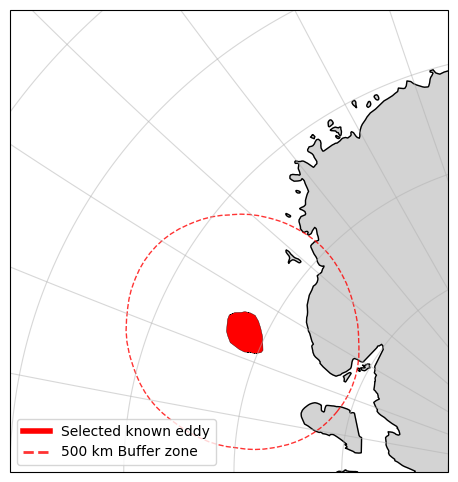

In [ ]:
%matplotlib inline
#plot the selected eddy and the buffered eddy
fig, ax = plt.subplots(figsize=(13, 6), subplot_kw={'projection': ccrs.TransverseMercator(central_longitude=30)})
ax.set_extent([300, 360, -80, -65], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND, color='lightgray')
ax.gridlines(alpha=0.5)

# Plot the selected eddy
ax.add_geometries(
    [selected_eddy['geometry']], crs=ccrs.PlateCarree(),
    facecolor="red", edgecolor="black", linewidth=0.25,
)

# Plot the buffered eddy
ax.add_geometries(
    [selected_eddy_buffered], crs=ccrs.epsg(6932),
    facecolor="none", edgecolor="red", linewidth=1,
    linestyle = '--', alpha=0.8
)

# Add a legend
eddy_proxy = mlines.Line2D([], [], color='red', linewidth=4, label="Selected known eddy")
buffer_proxy = mlines.Line2D([], [], color='red', linewidth=2, linestyle='--', alpha=0.8, label=f"{int(buffer/1e3)} km Buffer zone")
ax.legend(handles=[eddy_proxy, buffer_proxy], loc='lower left')

plt.show()

In [ ]:
# Convert the GeoFootprint column into shapely geometries
search_results_df["geometry_wkt"] = search_results_df["Footprint"].str.replace(r"geography'SRID=\d+;", "", regex=True)
search_results_df["geometry_wkt"] = search_results_df["geometry_wkt"].str.replace("'", "", regex=False)
search_results_df["geometry"] = search_results_df["geometry_wkt"].apply(wkt.loads)

# Convert the DataFrame to a GeoDataFrame
search_results_gdf = gpd.GeoDataFrame(search_results_df, geometry='geometry', crs='EPSG:4326')

#Conver the CRS to EPSG:6931
search_results_gdf = search_results_gdf.to_crs('EPSG:6932')

# Find results that intersect with the buffered eddy
intersecting_products = search_results_gdf[search_results_gdf["geometry"].intersects(selected_eddy_buffered)]

print(f'{len(intersecting_products)} products of {len(search_results_gdf)} in the date range intersect with the selected eddy')
intersecting_products.head()

119 products of 867 in the date range intersect with the selected eddy


@odata.mediaContentType                                    Id  \
57  application/octet-stream  7fe843f4-40e8-3041-b4a6-d2b1c51d549d   
60  application/octet-stream  b19d7956-64fa-3815-b4af-69d1a441e0a8   
61  application/octet-stream  1c7b6998-6851-3b2e-a222-7f91593401a6   
75  application/octet-stream  765090a6-b8a0-3eb0-8daa-e365b4533df9   
76  application/octet-stream  4b1d7d10-5e83-3f7b-b241-54d25a908dbf   

                                                 Name  \
57  S3A_SR_2_LAN_SI_20190106T010816_20190106T01263...   
60  S3B_SR_2_LAN_SI_20190106T020909_20190106T02271...   
61  S3A_SR_2_LAN_SI_20190106T024839_20190106T03062...   
75  S3B_SR_2_LAN_SI_20190106T085138_20190106T09105...   
76  S3A_SR_2_LAN_SI_20190106T093124_20190106T09495...   

                 ContentType  ContentLength                   OriginDate  \
57  application/octet-stream       25754332  2023-10-13T12:10:03.920000Z   
60  application/octet-stream       27247538  2023-10-15T15:44:32.487000Z   
61  application/octet-stream       27139571  2023-10-13T12:18:45.308000Z   
75  application/octet-stream       34703124  2023-10-15T15:41:27.956000Z   
76  application/octet-stream       39753341  2023-10-13T12:33:50.254000Z   

                PublicationDate             ModificationDate  Online  \
57  2023-10-19T21:46:54.761296Z  2023-10-19T21:46:56.225171Z    True   
60  2023-10-20T16:09:52.319379Z  2023-10-20T16:09:53.596763Z    True   
61  2023-10-19T21:45:38.943109Z  2023-10-19T21:45:40.291597Z    True   
75  2023-10-20T16:00:58.541775Z  2023-10-20T16:01:00.877322Z    True   
76  2023-10-19T21:43:01.336107Z  2023-10-19T21:43:05.562277Z    True   

                   EvictionDate  ...  \
57  9999-12-31T23:59:59.999999Z  ...   
60  9999-12-31T23:59:59.999999Z  ...   
61  9999-12-31T23:59:59.999999Z  ...   
75  9999-12-31T23:59:59.999999Z  ...   
76  9999-12-31T23:59:59.999999Z  ...   

                                             Checksum  \
57  [{'Value': '2a4833350b1319ff4ad22f2eebfde5b0',...   
60  [{'Value': 'f448daea480d70c20a9502c1a0fdaa9c',...   
61  [{'Value': '713b42fe2edd6d47622cd3427b1b09e5',...   
75  [{'Value': 'c88260df68a89e43a97f38971299ac21',...   
76  [{'Value': '415c8e92c5d89ae769aa1ff3cc9f8ae2',...   

                                          ContentDate  \
57  {'Start': '2019-01-06T01:08:15.696757Z', 'End'...   
60  {'Start': '2019-01-06T02:09:09.459514Z', 'End'...   
61  {'Start': '2019-01-06T02:48:38.661360Z', 'End'...   
75  {'Start': '2019-01-06T08:51:37.840999Z', 'End'...   
76  {'Start': '2019-01-06T09:31:23.996291Z', 'End'...   

                                            Footprint  \
57  geography'SRID=4326;POLYGON ((118.32 -59.1195,...   
60  geography'SRID=4326;POLYGON ((104.176 -57.0922...   
61  geography'SRID=4326;POLYGON ((94.3754 -57.0602...   
75  geography'SRID=4326;POLYGON ((5.89847 -52.0199...   
76  geography'SRID=4326;POLYGON ((-4.38085 -52.961...   

                                         GeoFootprint Satellite  \
57  {'type': 'Polygon', 'coordinates': [[[118.32, ...       S3A   
60  {'type': 'Polygon', 'coordinates': [[[104.176,...       S3B   
61  {'type': 'Polygon', 'coordinates': [[[94.3754,...       S3A   
75  {'type': 'Polygon', 'coordinates': [[[5.89847,...       S3B   
76  {'type': 'Polygon', 'coordinates': [[[-4.38085...       S3A   

                       SensingStart                       SensingEnd Cycle  \
57 2019-01-06 01:08:15.696757+00:00 2019-01-06 01:26:37.599477+00:00   040   
60 2019-01-06 02:09:09.459514+00:00 2019-01-06 02:27:17.630665+00:00   020   
61 2019-01-06 02:48:38.661360+00:00 2019-01-06 03:06:22.818448+00:00   040   
75 2019-01-06 08:51:37.840999+00:00 2019-01-06 09:10:50.111551+00:00   020   
76 2019-01-06 09:31:23.996291+00:00 2019-01-06 09:49:58.720360+00:00   040   

                                         geometry_wkt  \
57  POLYGON ((118.32 -59.1195, 117.112 -60.8462, 1...   
60  POLYGON ((104.176 -57.0922, 103.07 -58.8564, 1...   
61  POLYGON ((94.3754 -57.0602, 93.263

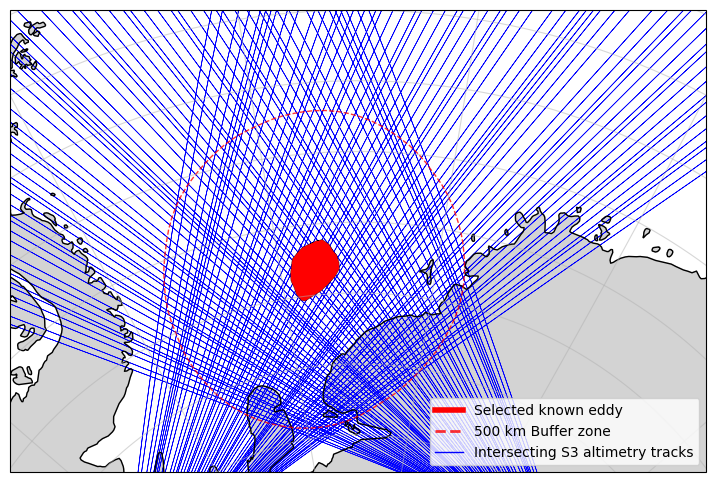

In [ ]:
%matplotlib inline
#plot the search results geometries
fig, ax = plt.subplots(figsize=(13, 6), subplot_kw={'projection': ccrs.TransverseMercator(central_longitude=330) })
ax.set_extent([300, 360, -80, -65], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND, color='lightgray')
ax.gridlines(alpha=0.5)

# Plot the selected eddy
ax.add_geometries(
    [selected_eddy['geometry']], crs=ccrs.PlateCarree(),
    facecolor="red", edgecolor="black", linewidth=0.25,
)

# Plot the buffered eddy
ax.add_geometries(
    [selected_eddy_buffered], crs=ccrs.epsg(6932),
    facecolor="none", edgecolor="red", linewidth=1,
    linestyle = '--', alpha=0.8
)

# Plot the search results
intersecting_products.plot(ax=ax, facecolor="none", edgecolor="blue", linewidth=0.5, transform=ccrs.epsg(6932))

# Add a legend
eddy_proxy = mlines.Line2D([], [], color='red', linewidth=4, label="Selected known eddy")
buffer_proxy = mlines.Line2D([], [], color='red', linewidth=2, linestyle='--', alpha=0.8, label=f"{int(buffer/1e3)} km Buffer zone")
s3_proxy = mlines.Line2D([], [], color='blue', linewidth=1, label="Intersecting S3 altimetry tracks")
ax.legend(handles=[eddy_proxy, buffer_proxy, s3_proxy], loc='lower right')

plt.show()



### Download Data


In [ ]:
target_dir = week8_path / 'S3_SRAL' / f'Eddy_num_{selected_eddy["track_number"]}'
target_dir.mkdir(exist_ok=True, parents=True)

cop_dspace_usrnm = 'zcfbjye@ucl.ac.uk' # copernicus dataspace username
cop_dspace_psswrd = '$p56zMgf2L6q+%y' # copernicus dataspace password

token, refresh_token = get_access_token(cop_dspace_usrnm, cop_dspace_psswrd)

for i, row in intersecting_products.iterrows():
    download_S3_from_df(row, token, target_dir)
print('Downloaded all products :)')

Downloaded all products :)


End of Part 1

# Part 2

# Install and Load GPSAT

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = True

if IN_COLAB:
    import sys
    import os
    import re

    # change to working directory
    work_dir = os.getcwd()

    assert os.path.exists(work_dir), f"workspace directory: {work_dir} does not exist"
    os.chdir(work_dir)

    # clone repository
    ! git clone https://github.com/CPOMUCL/GPSat.git

    repo_dir = os.path.join(work_dir, "GPSat")

    print(f"changing directory to: {repo_dir}")
    os.chdir(repo_dir)

    ! pip install -r requirements.txt

    ! pip install -e .

    ! pip install --upgrade pandas

    print(f"changing directory back to: {work_dir}")
    os.chdir(work_dir)

    sys.path.append(os.path.join(repo_dir, "GPSat"))


fatal: destination path 'GPSat' already exists and is not an empty directory.
changing directory to: /content/GPSat
Ignoring setuptools: markers 'python_version >= "3.12"' don't match your environment
Ignoring tensorflow: markers 'platform_system == "Darwin" and platform_machine == "x86_64"' don't match your environment
Ignoring tensorflow-macos: markers 'platform_system == "Darwin" and platform_machine == "arm64"' don't match your environment
Ignoring gpflow: markers 'platform_system == "Darwin" and platform_machine == "arm64"' don't match your environment
  Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.0 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3
ERROR: pip's dependency resolver does not currently take into account all the package

In [ ]:
gpsat_repo_dir = os.path.join(os.getcwd(), "GPSat/")
sys.path.append(gpsat_repo_dir)
import sys
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Proj, transform
from pathlib import Path
from scipy.spatial import KDTree
from GPSat import get_data_path, get_parent_path
from GPSat.dataprepper import DataPrep
from GPSat.utils import WGS84toEASE2_New, EASE2toWGS84_New, cprint, grid_2d_flatten, get_weighted_values
from GPSat.local_experts import LocalExpertOI, get_results_from_h5file
from GPSat.plot_utils import plot_pcolormesh, get_projection, plot_pcolormesh_from_results_data
from GPSat.config_dataclasses import DataConfig, ModelConfig, PredictionLocsConfig, ExpertLocsConfig
from GPSat.postprocessing import glue_local_predictions_2d
from global_land_mask import globe
import matplotlib.lines as mlines

In [ ]:
week8_path= Path('/content/drive/MyDrive/GEOL0069_AI_for_Earth_Observation/Week8/Notebook/drive-download-20250314T110653Z-001/')

# Loading selected eddy data and Sentinel 3 from part 1

In [ ]:
#Load the selected eddy data
eddy_number = 719364
date = pd.to_datetime("2019-01-13").date()
#load the selected eddy
selected_eddy = gpd.read_file(week8_path / f"selected_eddy_{date}_{eddy_number}.gpkg", layer='row')

In [ ]:
#The eddy coords use the 0-360 longitude convention, let's change them to -180 to 180 for consistency with the EPSG:4326 projection

from shapely.geometry import Polygon

# Function to shift longitudes from 0-360 to -180 to 180
def shift_longitude(geometry):
    if geometry.geom_type == "Polygon":
        new_coords = [((lon - 360 if lon > 180 else lon), lat) for lon, lat in geometry.exterior.coords]
        return Polygon(new_coords)
    elif geometry.geom_type == "MultiPolygon":
        new_polygons = []
        for poly in geometry.geoms:
            new_coords = [((lon - 360 if lon > 180 else lon), lat) for lon, lat in poly.exterior.coords]
            new_polygons.append(Polygon(new_coords))
        return gpd.GeoSeries(new_polygons).unary_union  # Convert list back to MultiPolygon
    return geometry

selected_eddy["geometry"] = selected_eddy["geometry"].apply(shift_longitude)
selected_eddy = selected_eddy.set_crs('EPSG:4326')


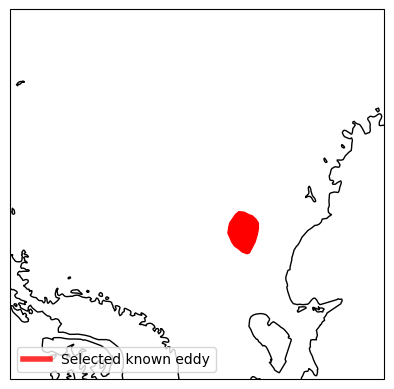

In [ ]:
#plot the selected eddy location
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.SouthPolarStereo()})
ax.set_extent([-10, -60, -80, -65], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_geometries([selected_eddy.geometry.iloc[0]], crs=ccrs.PlateCarree(), facecolor='red', edgecolor='red')
eddy_proxy = mlines.Line2D([], [], color='red', linewidth=4, alpha=0.8, label="Selected known eddy")
ax.legend(handles=[eddy_proxy], loc='lower left')
plt.show()

# Compute SSHA based on Sentinel-3 data

In [ ]:
def add_sea_surface_height_and_anomaly(sral_ds):
    """
    Calculate the sea surface height anomaly from a Sentinel-3 SRAL dataset.
    Based on the L2 WAT definition:
    SSHA = altitude of satellite (alt_20_ku) - Ku band corrected ocean altimeter range (range_ocean_20_ku)
    - filtered altimeter ionospheric correction on Ku band (iono_cor_alt_filtered_01_ku)
    - model dry tropospheric correction (mod_dry_tropo_cor_zero_altitude_01)
    - radiometer wet tropospheric correction (rad_wet_tropo_cor_01_ku)
    - sea state bias correction in Ku band (sea_state_bias_01_ku)
    - solid earth tide height (solid_earth_tide_01)
    - geocentric ocean tide height solution 2 = FES (ocean_tide_sol2_01)
    - geocentric pole tide height (pole_tide_01)
    - inverted barometer height correction (inv_bar_cor_01)
    - high frequency fluctuations of the sea surface topography (hf_fluct_cor_01 for NTC/STC off line products only)
    - mean sea surface (mean_sea_surf_sol2_20_ku)"

    Parameters:
    sral_ds (xarray.Dataset): The Sentinel-3 SRAL dataset.
    Returns:
    The Sentinel-3 SRAL dataset with the calculated sea surface height and sea surface height anomaly.
    """

    #Before we can calculate the sea surface height anomaly (SSHA), we need to interpolate the 1Hz corrections to the 20Hz data
    mod_dry_tropo_cor_zero_altitude_20_ku = sral_ds.mod_dry_tropo_cor_zero_altitude_01.interp(time_01=sral_ds.time_20_ku)
    iono_cor_alt_filtered_20_ku = sral_ds.iono_cor_alt_filtered_01_ku.interp(time_01=sral_ds.time_20_ku)
    rad_wet_tropo_cor_20_ku = sral_ds.rad_wet_tropo_cor_01_ku.interp(time_01=sral_ds.time_20_ku)
    sea_state_bias_20_ku = sral_ds.sea_state_bias_01_ku.interp(time_01=sral_ds.time_20_ku)
    solid_earth_tide_20_ku = sral_ds.solid_earth_tide_01.interp(time_01=sral_ds.time_20_ku)
    ocean_tide_sol2_20_ku = sral_ds.ocean_tide_sol2_01.interp(time_01=sral_ds.time_20_ku)
    pole_tide_20_ku = sral_ds.pole_tide_01.interp(time_01=sral_ds.time_20_ku)
    inv_bar_cor_20_ku = sral_ds.inv_bar_cor_01.interp(time_01=sral_ds.time_20_ku)
    hf_fluct_cor_20_ku = sral_ds.hf_fluct_cor_01.interp(time_01=sral_ds.time_20_ku)

    # Calculate the sea surface height
    ssh = sral_ds.alt_20_ku - sral_ds.range_water_20_ku - iono_cor_alt_filtered_20_ku - mod_dry_tropo_cor_zero_altitude_20_ku - rad_wet_tropo_cor_20_ku - sea_state_bias_20_ku - solid_earth_tide_20_ku - ocean_tide_sol2_20_ku - pole_tide_20_ku - inv_bar_cor_20_ku - hf_fluct_cor_20_ku

    ssh.attrs = {
        "long_name": "Sea Surface Height",
        "units": "m",
        "standard_name": "sea_surface_height_above_sea_leved",
        "comment": "Calculated as SSH = altitude of satellite (alt_20_ku) - Ku band corrected ocean altimeter range (range_ocean_20_ku) - filtered altimeter ionospheric correction on Ku band (iono_cor_alt_filtered_01_ku) - model dry tropospheric correction (mod_dry_tropo_cor_zero_altitude_01) - radiometer wet tropospheric correction (rad_wet_tropo_cor_01_ku) - sea state bias correction in Ku band (sea_state_bias_01_ku) - solid earth tide height (solid_earth_tide_01) - geocentric ocean tide height solution 2 = FES (ocean_tide_sol2_01) - geocentric pole tide height (pole_tide_01) - inverted barometer height correction (inv_bar_cor_01) - high frequency fluctuations of the sea surface topography (hf_fluct_cor_01 for NTC/STC off line products only)"
    }

    sral_ds['ssh_20_ku'] = ssh

    # Calculate the sea surface height anomaly
    ssha = ssh - sral_ds.mean_sea_surf_sol2_20_ku

    ssha.attrs = {
        "long_name": "Sea Surface Height Anomaly",
        "units": "m",
        "standard_name": "sea_surface_height_above_sea_leved",
        "comment": "Calculated as SSHA = ssha - mean sea surface (mean_sea_surf_sol2_20_ku)"
    }

    sral_ds['ssha_20_ku'] = ssha

    return sral_ds

In [ ]:
eddy_sral_dir = week8_path / 'S3_SRAL' / f'Eddy_num_{eddy_number}'

#load in the data
sral_filepaths = list(eddy_sral_dir.glob('**/*enhanced_measurement.nc'))
vars_of_interest = ['ssha_20_ku', 'ssh_20_ku', 'range_water_20_ku', 'alt_20_ku', 'sea_ice_ssha_20_ku', 'int_sea_ice_ssha_20_ku', 'mean_sea_surf_sol2_20_ku', 'sea_ice_sea_surf_20_ku', 'surf_type_class_20_ku', 'sea_ice_concentration_20_ku', 'freeboard_20_ku', 'dist_coast_20_ku']
sral_datasets = []
for sral_filepath in sral_filepaths:
    ds = xr.open_dataset(sral_filepath)
    ds = add_sea_surface_height_and_anomaly(ds)
    ds = ds[vars_of_interest]
    #crop to 60deg S
    ds = ds.where(ds.lat_20_ku <= -60, drop=True)
    #buffer by coast
    ds = ds.where(ds.dist_coast_20_ku >= 25e3, drop=True)
    sral_datasets.append(ds)
sral_ds = xr.concat(sral_datasets, dim='time_20_ku')

del sral_datasets, ds

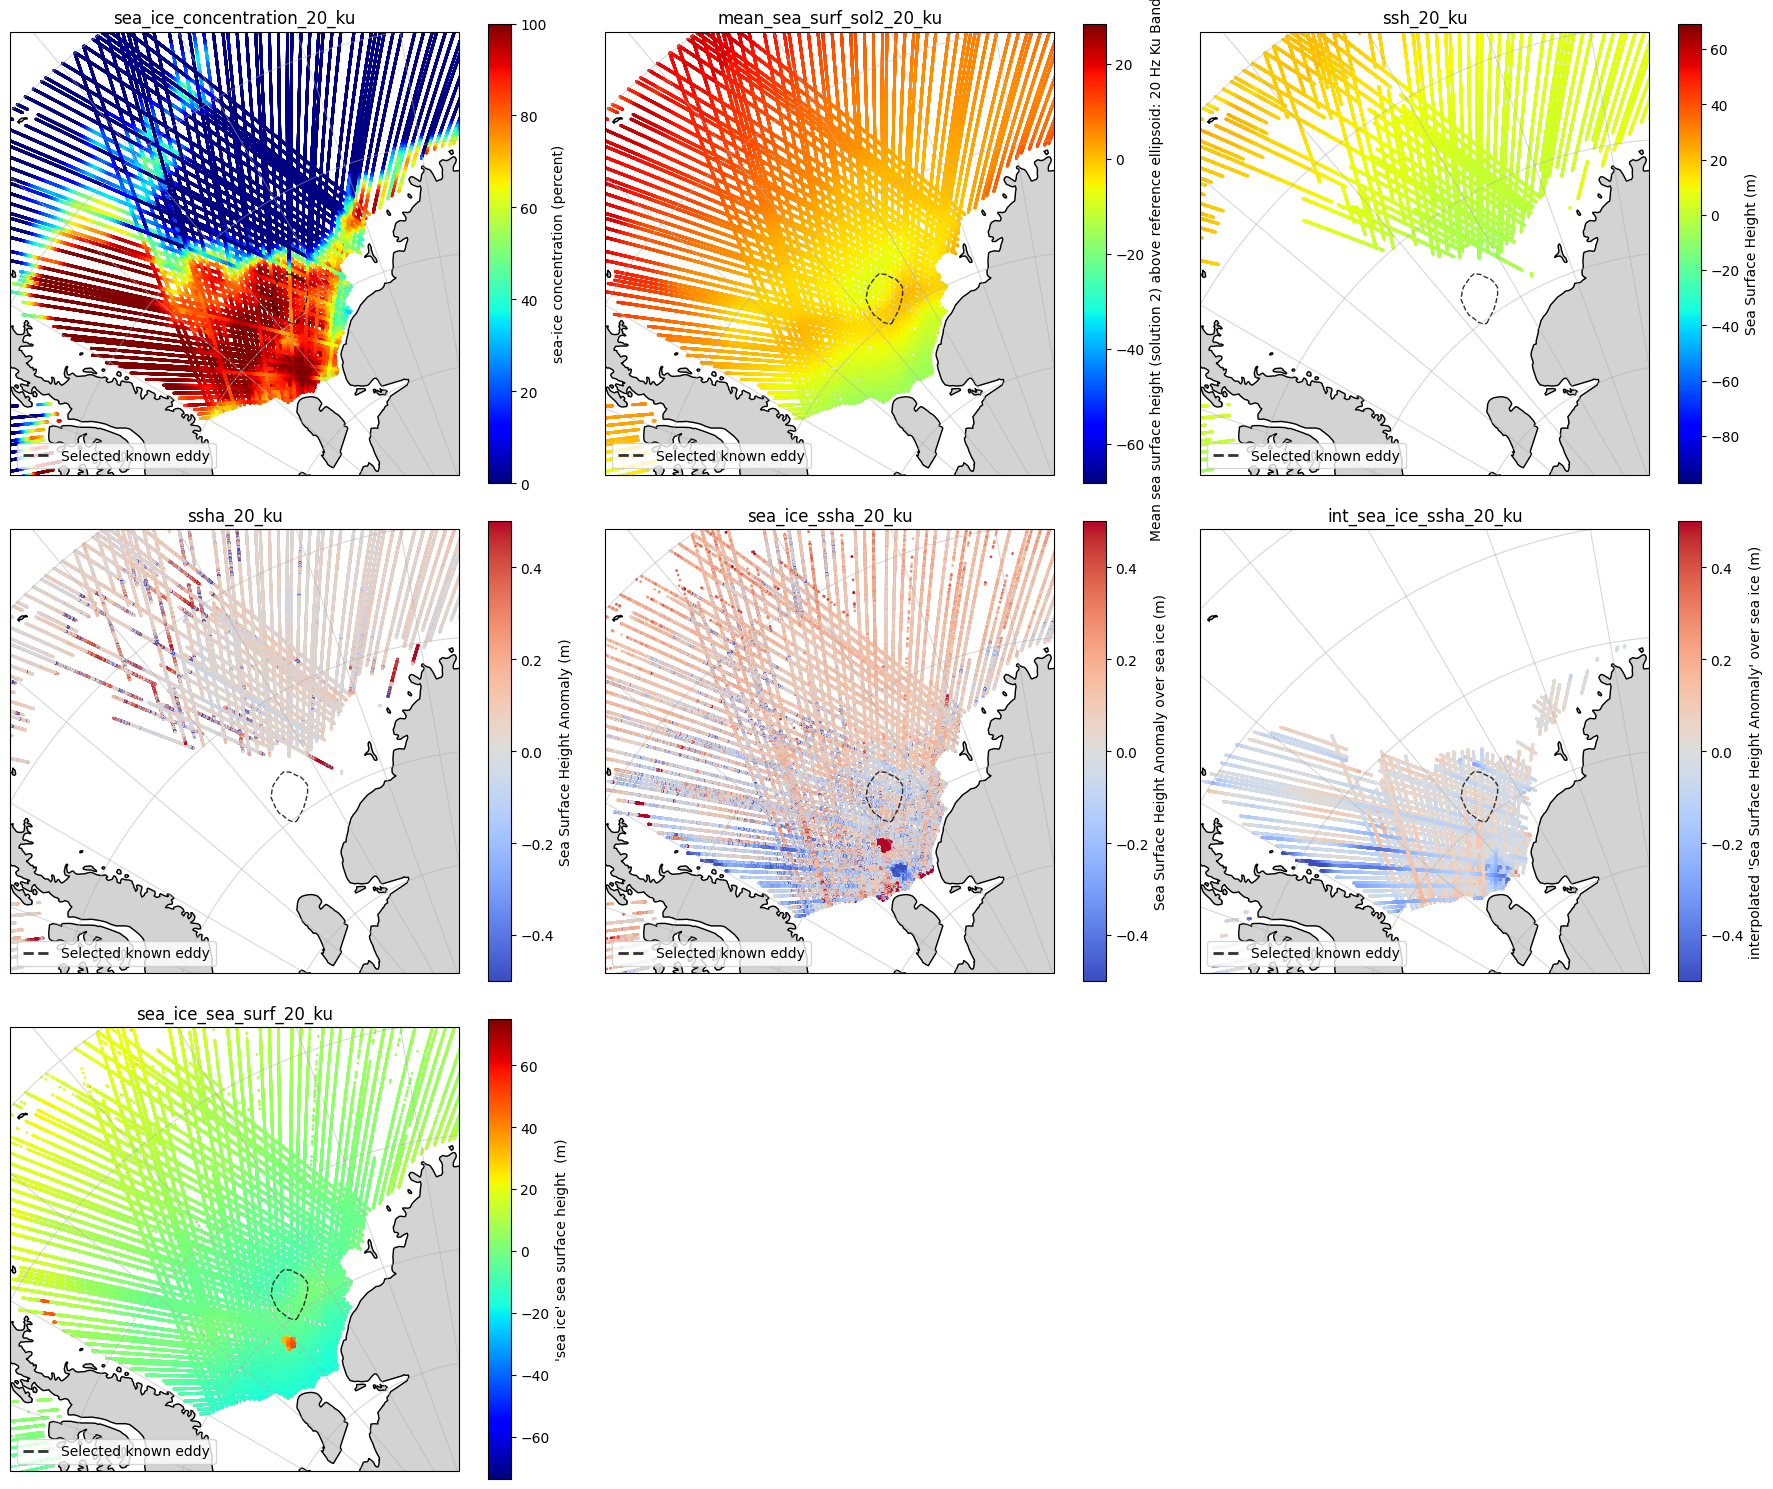

In [ ]:

#Plot each of the variables of interest in the general vicinity of the eddy
vars_to_plot = ['sea_ice_concentration_20_ku', 'mean_sea_surf_sol2_20_ku', 'ssh_20_ku', 'ssha_20_ku', 'sea_ice_ssha_20_ku', 'int_sea_ice_ssha_20_ku', 'sea_ice_sea_surf_20_ku']

%matplotlib inline
fig, axs = plt.subplots(3, 3, figsize=(18, 15), subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs = axs.flatten()
eddy_proxy = mlines.Line2D([], [], color='black', linewidth=2, linestyle='--', alpha=0.8, label="Selected known eddy")
for i, var in enumerate(vars_to_plot):
    ax = axs[i]
    ax.set_extent([-10, -60, -80, -65], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.gridlines(alpha=0.5)
    if 'ssha' in var:
        sm = ax.scatter(sral_ds['lon_20_ku'], sral_ds['lat_20_ku'], c=sral_ds[var], cmap='coolwarm', transform=ccrs.PlateCarree(), s=1, vmin=-0.5, vmax=0.5)
    else:
        sm = ax.scatter(sral_ds['lon_20_ku'], sral_ds['lat_20_ku'], c=sral_ds[var], cmap='jet', transform=ccrs.PlateCarree(), s=1)
    cbar_label = sral_ds[var].long_name.split(': 20 Hz Ku band')[0]
    if 'units' in sral_ds[var].attrs:
        cbar_label += f" ({sral_ds[var].units})"
    fig.colorbar(sm, ax=ax, label=cbar_label)
    ax.set_title(var)

    #add the polygon of the selected eddy
    ax.add_geometries(
        [selected_eddy.iloc[0]['geometry']], crs=ccrs.PlateCarree(),
        facecolor="none", edgecolor="black", linewidth=1, linestyle='--', alpha=0.8,
    )
    ax.legend(handles=[eddy_proxy], loc='lower left')
#turn off any unused axes
for ax in axs[len(vars_to_plot):]:
    ax.axis('off')
plt.tight_layout()

 **Result summary and analysis**

Firstly, the above figure on sea ice concentration shows that even in southern hemisphere summer ( Data is from January 2019 ),
there is significant amount of sea ice left near the coast in Weddell sea which is in the zone of the area of interest. This is because Weddell sea where the above figure is located has a lot of multi-year sea ice due to very low temperature current called Weddell current.

The mean sea surface almost correlates inversely with sea ice concentration as sea ice concentration increases mean sea surface height decreases. This trend is also displayed in SSHA but to a lesser extent.

In area with high concentration of sea ice, **SSHA tends to be lower while SSHA tends to be higher in area with low concentration of sea ice.** However, this is not perfectly correlated and there are some anomalies.

This is caused as thick multi year sea ice that is found near Weddell sea can decrease the sea level due to isostatic effect (Whitehouse,2018). The anomaly is likely caused in some regions due to large polynyas which are directly exposed to open sea water.

**On the other hand, area with little sea ice concentration has positive SSHA which can potentially support rise in sea level due to global warming and sea ice melting.** This is because rise in sea level has been observed over large areas. However, this might be due to storm surge or other factors as well so more data should be obtained for verification.

Overall the altimetry data shows a good indication of SSHA in southern ocean but there are several gaps in between due to the tracks so the interpolation using GPSAT need to be used to fill in those gaps.




# **Optically interpolating SSHA based by Using GPSAT**

### **Format the data set**

In [ ]:
#convert sral_ds to a pandas dataframe
sral_df = (sral_ds
           .to_dataframe()
           .reset_index())

#To make it simpler to retieve this eddy without worrying about ice-floe-contaminated data, we will just take points where the sea ice concentration is zero.
#We are therefore negleting any SSH measurements coming from leads in the nearby icepack.
sral_df = sral_df[sral_df['sea_ice_concentration_20_ku'] == 0]

sral_df.head()

time_20_ku  ssha_20_ku  ssh_20_ku  range_water_20_ku  \
0 2019-01-16 11:16:06.069545088   -0.008049  21.337951        825997.7005   
1 2019-01-16 11:16:06.120264064    0.059816  21.406416        825998.6247   
2 2019-01-16 11:16:06.170983296   -0.046720  21.299980        825999.7236   
3 2019-01-16 11:16:06.221702400    0.057345  21.402645        826000.6134   
4 2019-01-16 11:16:06.272408448    0.041309  21.383509        826001.6247   

     alt_20_ku  sea_ice_ssha_20_ku  int_sea_ice_ssha_20_ku  \
0  826016.5923                 NaN                     NaN   
1  826017.5850                 NaN                     NaN   
2  826018.5775                 NaN                     NaN   
3  826019.5700                 NaN                     NaN   
4  826020.5622                 NaN                     NaN   

   mean_sea_surf_sol2_20_ku  sea_ice_sea_surf_20_ku  surf_type_class_20_ku  \
0                   21.3460                     NaN                    0.0   
1                   21.3466                     NaN                    0.0   
2                   21.3467                     NaN                    0.0   
3                   21.3453                     NaN                    0.0   
4                   21.3422                     NaN                    0.0   

   sea_ice_concentration_20_ku  freeboard_20_ku  dist_coast_20_ku  lat_20_ku  \
0                          0.0              NaN          386973.0 -60.001523   
1                          0.0              NaN          387115.0 -60.004385   
2                          0.0              NaN          387257.0 -60.007246   
3                          0.0              NaN          387400.0 -60.010108   
4                          0.0              NaN          387542.0 -60.012968   

    lon_20_ku  
0  325.776772  
1  325.774770  
2  325.772768  
3  325.770766  
4  325.768764

In [ ]:
# Format the dataframe to the convention used for the GPSat package
sral_df['t'] = sral_df['time_20_ku'].values.astype("datetime64[D]").astype(float)
sral_df['x'], sral_df['y'] = WGS84toEASE2_New(sral_df['lon_20_ku'].values, sral_df['lat_20_ku'].values, lat_0=-90)

<ipython-input-11-85fc6bf772d1>:3: DeprecationWarning: Call to deprecated function (or staticmethod) WGS84toEASE2_New. (This function will be removed in future versions. Use `WGS84toEASE2` instead.)
  sral_df['x'], sral_df['y'] = WGS84toEASE2_New(sral_df['lon_20_ku'].values, sral_df['lat_20_ku'].values, lat_0=-90)


### **Define a region of interest**


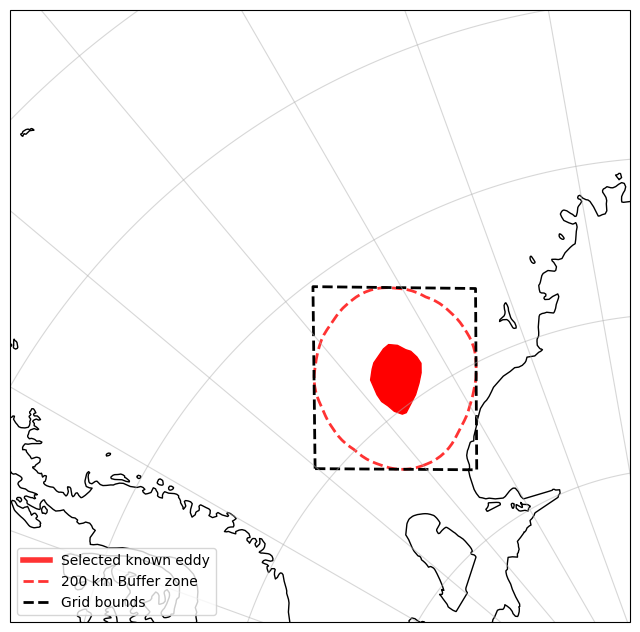

In [ ]:
# We need to define some grids, one for our expert locations and one for our prediction locations
# To help us create a grid in the relevant location and coordinate system, we'll start by making a buffer zone around the eddy and obtain its bounds
buffer = 200e3 #m
buffered_eddy = selected_eddy['geometry'].to_crs('EPSG:6932').iloc[0].buffer(buffer) #note that we must change the polygon crs to get a buffer in metres
minx, miny, maxx, maxy = buffered_eddy.bounds

selected_eddy = selected_eddy.to_crs('EPSG:4326')

#plot the eddy, buffer and the bounds
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.SouthPolarStereo()})
ax.set_extent([-10, -60, -80, -65], crs=ccrs.PlateCarree())
ax.add_geometries([selected_eddy.iloc[0].geometry], crs=ccrs.PlateCarree(), facecolor='red', edgecolor='red')
ax.add_geometries([buffered_eddy], crs=ccrs.epsg(6932), facecolor='none', edgecolor='red', linewidth=2, linestyle='--', alpha=0.8)
buffer_boundary = ax.plot([minx, maxx, maxx, minx, minx], [miny, miny, maxy, maxy, miny], transform=ccrs.epsg(6932), color='black', linestyle='--', linewidth=2, label='Grid bounds')
ax.coastlines()
ax.gridlines(alpha=0.5)
eddy_proxy = mlines.Line2D([], [], color='red', linewidth=4, alpha=0.8, label="Selected known eddy")
buffer_proxy = mlines.Line2D([], [], color='red', linewidth=2, linestyle='--', alpha=0.8, label=f"{int(buffer/1e3)} km Buffer zone")
ax.legend(handles=[eddy_proxy, buffer_proxy, buffer_boundary[0]], loc='lower left')
plt.show()

### **Define local expert**

In [ ]:
#Make a grid of expert locations using the bounds
expert_grid_res = 30e3
grid_xcs = np.arange(minx, maxx+expert_grid_res/2, expert_grid_res) #remember that the start is included and the stop is not
grid_ycs = np.arange(miny, maxy+expert_grid_res/2, expert_grid_res)
grid_xcs_2d, grid_ycs_2d = np.meshgrid(grid_xcs, grid_ycs)
expert_locs = pd.DataFrame({'x': grid_xcs_2d.flatten(), 'y': grid_ycs_2d.flatten()})
# Add lon and lat
expert_locs['lon'], expert_locs['lat'] = EASE2toWGS84_New(expert_locs['x'], expert_locs['y'], lat_0=-90)
expert_locs['t'] = np.floor(sral_df['t'].mean())
# Identify if a position is in the ocean (water) or not
expert_locs["is_in_ocean"] = globe.is_ocean(expert_locs['lat'], expert_locs['lon'])
# keep only prediction locations in ocean
expert_locs = expert_locs.loc[expert_locs["is_in_ocean"]]
print(f'Number of expert locations: {len(expert_locs)}')
print("Local expert locations:")
expert_locs.head()

Number of expert locations: 455
Local expert locations:


<ipython-input-13-a20697b3575a>:8: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  expert_locs['lon'], expert_locs['lat'] = EASE2toWGS84_New(expert_locs['x'], expert_locs['y'], lat_0=-90)


x             y        lon        lat        t  is_in_ocean
0 -1.330645e+06  1.108854e+06 -50.194857 -74.440899  17909.0         True
1 -1.300645e+06  1.108854e+06 -49.551027 -74.648302  17909.0         True
2 -1.270645e+06  1.108854e+06 -48.889767 -74.853647  17909.0         True
3 -1.240645e+06  1.108854e+06 -48.210541 -75.056855  17909.0         True
4 -1.210645e+06  1.108854e+06 -47.512808 -75.257842  17909.0         True

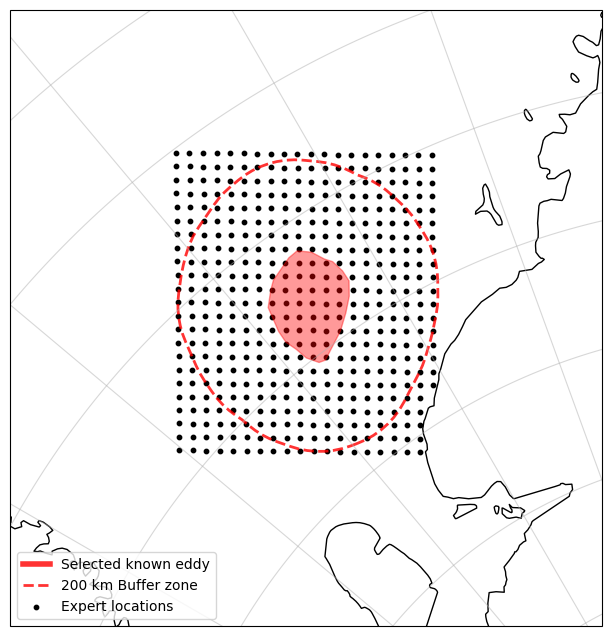

In [ ]:
# Plot the eddy, buffer and the bounds
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.SouthPolarStereo()})
ax.set_extent([-50, -20, -80, -70], crs=ccrs.PlateCarree())
ax.add_geometries(selected_eddy.geometry, crs=ccrs.PlateCarree(), facecolor='red', edgecolor='red', alpha=0.4)
ax.add_geometries([buffered_eddy], crs=ccrs.epsg(6932), facecolor='none', edgecolor='red', linewidth=2, linestyle='--', alpha=0.8)
elocs = ax.scatter(expert_locs['x'], expert_locs['y'], transform=ccrs.epsg(6932), color='black', s=10, label='Expert locations')
ax.coastlines()
ax.gridlines(alpha=0.5)
eddy_proxy = mlines.Line2D([], [], color='red', linewidth=4, alpha=0.8, label="Selected known eddy")
buffer_proxy = mlines.Line2D([], [], color='red', linewidth=2, linestyle='--', alpha=0.8, label=f"{int(buffer/1e3)} km Buffer zone")
ax.legend(handles=[eddy_proxy, buffer_proxy, elocs], loc='lower left')
plt.show()

### **Define Prediction location**

In [ ]:
#Define a grid for the prediction locations
pred_grid_res = 5e3
pred_grid_xcs = np.arange(minx+pred_grid_res, maxx+pred_grid_res/2, pred_grid_res) #remember that the start is included and the stop is not
pred_grid_ycs = np.arange(miny+pred_grid_res, maxy+pred_grid_res/2, pred_grid_res)
pred_grid_xcs_2d, pred_grid_ycs_2d = np.meshgrid(pred_grid_xcs, pred_grid_ycs)
pred_locs = pd.DataFrame({'x': pred_grid_xcs_2d.flatten(), 'y': pred_grid_ycs_2d.flatten()})
# Add lon and lat columns
pred_locs['lon'], pred_locs['lat'] = EASE2toWGS84_New(pred_locs['x'].values, pred_locs['y'].values, lat_0=-90)

<ipython-input-15-279aa130fb4e>:8: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  pred_locs['lon'], pred_locs['lat'] = EASE2toWGS84_New(pred_locs['x'].values, pred_locs['y'].values, lat_0=-90)


### Bin observations (to reduce GPSat runtime)

In [ ]:
#Let us use the grid coordinates that we defined earlier for our prediction locations and use a KDTree to help bin the S3 data within each grid cell
gridded_obvs_dfs = []

for date_val, date_df in sral_df.groupby('t'):
  date_df = date_df.copy()
  gridded_observations = pd.DataFrame({'x': pred_grid_xcs_2d.flatten(), 'y': pred_grid_ycs_2d.flatten()})
  #get the nearest grid cell to each observation
  tree = KDTree(np.vstack([gridded_observations['x'].values, gridded_observations['y'].values]).T)
  distances, indices = tree.query(np.vstack([date_df['x'].values, date_df['y'].values]).T, k=1)
  #nan where dist > max dist
  max_dist = 2.5e4
  indices[distances > max_dist] = -9999
  #get the mean of the observations in each grid cell
  date_df['nearest_grid_cell_index'] = indices
  date_df = date_df.groupby('nearest_grid_cell_index').mean()
  #drop x and y from the averaged date_df as we don't want the mean coords for the grid cell data- we will obtain the actual grid cell x and y when we merge the two datasets
  date_df = date_df.drop(columns=['x', 'y'])
  #merge the binned date_df with the gridded_observations dataframe
  gridded_observations=gridded_observations.merge(date_df, left_index=True, right_index=True, how='left')
  #drop rows with nan ssha values
  ssha_var = 'ssha_20_ku'
  # ssha_var = 'sea_ice_ssha_20_ku'
  gridded_observations = gridded_observations.dropna(subset=[ssha_var])
  #add the t column
  gridded_observations['t'] = date_val
  gridded_obvs_dfs.append(gridded_observations)
  del date_df, gridded_observations, tree, distances, indices

gridded_obvs_df = pd.concat(gridded_obvs_dfs)
gridded_obvs_df = gridded_obvs_df.reset_index(drop=True)

del gridded_obvs_dfs
gridded_obvs_df.head()
print(f'We have reduced the number of observations from {len(sral_df)} to {len(gridded_obvs_df)}')


We have reduced the number of observations from 702212 to 527


In [ ]:
sral_df = sral_df.dropna(subset=['x', 'y', 't','ssha_20_ku']).reset_index(drop=True)
print(sral_df.shape)

(691056, 18)


###  **Set GPSat configuration parameters**

In [ ]:
# Set training and inference radius
training_radius = 100_000
inference_radius = 50_000

In [ ]:
# Local expert locations config
local_expert = ExpertLocsConfig(source = expert_locs)

# Model config
model = ModelConfig(oi_model = "GPflowSGPRModel", # Use GPflow SGPR model
# model = ModelConfig(oi_model = "GPflowGPRModel", # Use GPflow GPR model
                    init_params = {
                        # normalise xy coordinates
                        "coords_scale": [10_000, 10_000, 1],
                        'num_inducing_points':100
                        },
                    constraints = {
                        # set bounds on the lengthscale hyperparameters
                        "lengthscales": {
                            "low": [1e-08, 1e-08, 1e-08],
                            "high": [600_000, 600_000, 9]
                        }
                        }
                    )
# Define the training window (e.g., 7 days)
training_window = pd.Timedelta(days=7)

# Data config
data = DataConfig(data_source = sral_df,
                  obs_col = ssha_var,
                  coords_col = ["x", "y", "t"],
                  local_select = [
                    # Select data within the training window and radius
                    {"col": "t", "comp": "<=", "val": training_window.days},
                    {"col": "t", "comp": ">=", "val": -training_window.days},
                    {"col": ["x", "y"], "comp": "<", "val": training_radius}
                  ]
                )

# Prediction locs config
pred_loc = PredictionLocsConfig(method = "from_dataframe",
                                df = pred_locs,
                                max_dist = inference_radius)

In [ ]:
locexp = LocalExpertOI(expert_loc_config = local_expert,
                       data_config = data,
                       model_config = model,
                       pred_loc_config = pred_loc)

in json_serializable - key: 'source' has value DataFrame/Series, but is too long: 455 >  100
storing as str
'data_select': 0.000 seconds
'load': 0.000 seconds
in json_serializable - key: 'data_source' has value DataFrame/Series, but is too long: 691056 >  100
storing as str
in json_serializable - key: 'df' has value DataFrame/Series, but is too long: 14964 >  100
storing as str


### **Run GPSAT**

In [23]:
# path to store results
store_path = week8_path / 'OI_results' / f'Eddy_num_{eddy_number}_{date.strftime("%Y-%m-%d")}_{ssha_var}.h5'
if store_path.parent.exists() == False:
    store_path.parent.mkdir(parents=True)

In [22]:
# for the purposes of a simple example, if store_path exists: delete it
if os.path.exists(store_path):
    cprint(f"removing: {store_path}")
    os.remove(store_path)

# run optimal interpolation
locexp.run(store_path=str(store_path))

Streaming output truncated to the last 5000 lines.
               x             y        lon        lat        t  is_in_ocean
69 -1.060645e+06  1.198854e+06 -41.499693 -75.628305  17909.0         True
'local_data_select': 0.225 seconds
number obs: 0
--------------------------------------------------
68 / 455
current local expert:
               x             y        lon        lat        t  is_in_ocean
70 -1.030645e+06  1.198854e+06 -40.685379 -75.806337  17909.0         True
'local_data_select': 0.224 seconds
number obs: 0
--------------------------------------------------
69 / 455
current local expert:
               x             y        lon        lat        t  is_in_ocean
71 -1.000645e+06  1.198854e+06 -39.850668 -75.981378  17909.0         True
'local_data_select': 0.225 seconds
number obs: 0
--------------------------------------------------
70 / 455
current local expert:
                x             y        lon        lat        t  is_in_ocean
72 -970644.774992  1.198854e+0

### **Glue Initial results**

In [24]:
# extract, store in dict
dfs, _ = get_results_from_h5file(store_path)

print(f"tables in results file: {list(dfs.keys())}")

reading in results
getting all tables
merging on expert location data
table: 'oi_config' does not have all coords_col: ['x', 'y', 't'] in columns, not merging on expert_locations
tables in results file: ['expert_locs', 'inducing_points', 'kernel_variance', 'lengthscales', 'likelihood_variance', 'oi_config', 'preds', 'run_details']


In [25]:
preds_data = dfs["preds"]
preds_data.head()
inference_radius = 50_000
# multiple local experts may make predictions at the same prediction location (pred_loc).
# - for each prediction at a given location, take we weighted combination
# - weights being a function of the distance to each local expert that made a prediction at a given location.
plt_data = glue_local_predictions_2d(preds_df=preds_data,
                                     pred_loc_cols=["pred_loc_x", "pred_loc_y"],
                                     xprt_loc_cols=["x", "y"],
                                     vars_to_glue=["f*", "f*_var"],
                                     inference_radius=inference_radius)
plt_data['lon'],plt_data['lat'] = EASE2toWGS84_New(plt_data['pred_loc_x'],plt_data['pred_loc_y'],lat_0=-90)
#Set to nan predictions that are not over the ocean
plt_data['is_ocean'] = globe.is_ocean(plt_data['lat'], plt_data['lon'])
plt_data.loc[plt_data['is_ocean'] == False, 'f*'] = np.nan
plt_data.head()

<ipython-input-25-4095873829f2>:12: DeprecationWarning: Call to deprecated function (or staticmethod) EASE2toWGS84_New. (This function will be removed in future versions. Use `EASE2toWGS84` instead.)
  plt_data['lon'],plt_data['lat'] = EASE2toWGS84_New(plt_data['pred_loc_x'],plt_data['pred_loc_y'],lat_0=-90)


pred_loc_x    pred_loc_y        f*    f*_var        lon        lat  \
0 -1.325645e+06  1.548854e+06  0.000012  0.001341 -40.559809 -71.663189   
1 -1.325645e+06  1.553854e+06  0.000012  0.001341 -40.468607 -71.628681   
2 -1.325645e+06  1.558854e+06  0.000012  0.001341 -40.377743 -71.594124   
3 -1.325645e+06  1.563854e+06  0.000012  0.001341 -40.287218 -71.559519   
4 -1.325645e+06  1.568854e+06  0.000012  0.001341 -40.197028 -71.524865   

   is_ocean  
0      True  
1      True  
2      True  
3      True  
4      True

## Visualise OI results

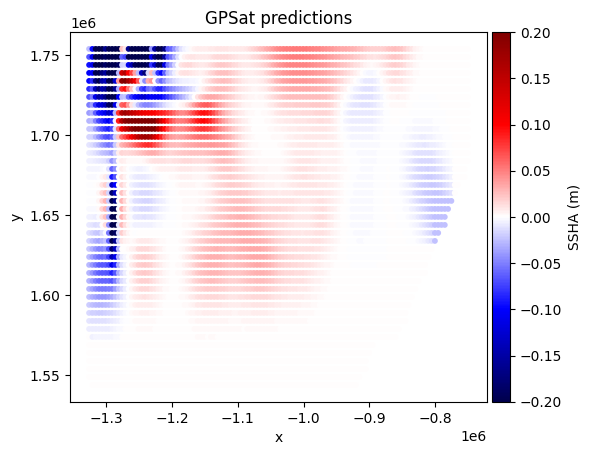

In [26]:
fig, ax = plt.subplots()
sla_preds = ax.scatter(plt_data['pred_loc_x'],plt_data['pred_loc_y'],c=plt_data['f*'],s=10,cmap='seismic',vmin=-0.2,vmax=0.2)
fig.colorbar(sla_preds, ax=ax, label='SSHA (m)', pad=0.01)
ax.set_title('GPSat predictions')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()


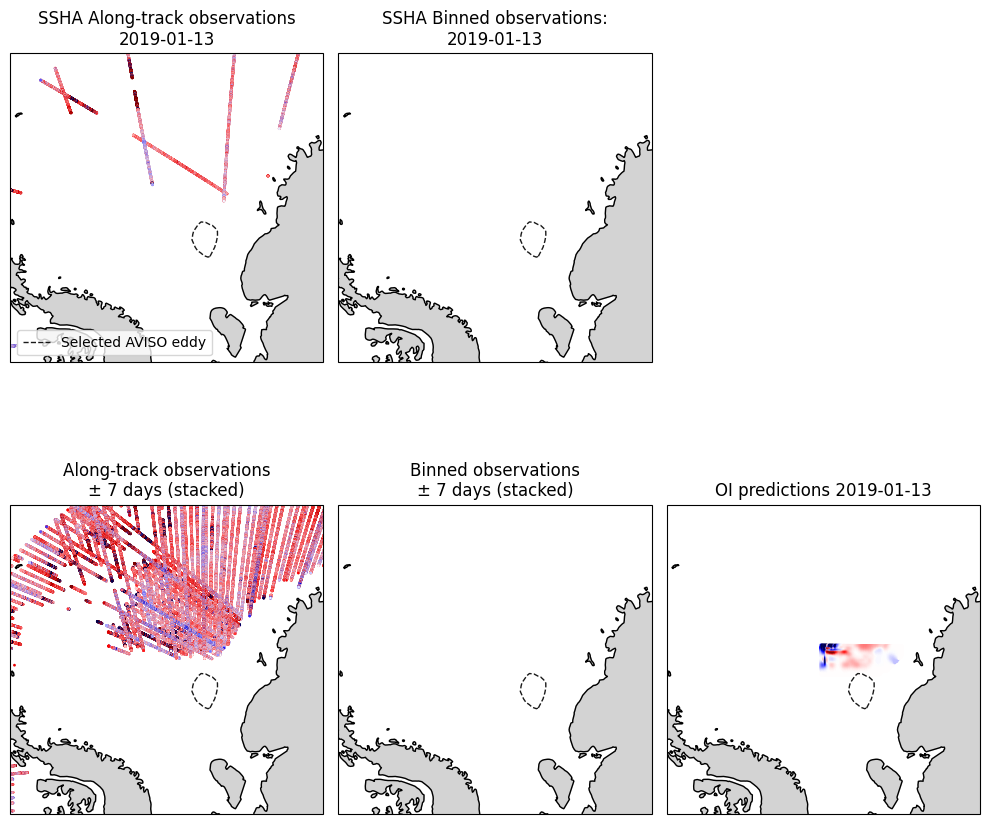

In [27]:
fig,axs = plt.subplots(2,3,figsize=(10,10),subplot_kw=dict(projection=ccrs.SouthPolarStereo()))
axs = axs.flatten()
eddy_proxy = mlines.Line2D([], [], color='black', linestyle='--', linewidth=1, alpha=0.9, label="Selected AVISO eddy")

for i, ax in enumerate(axs):
    if i == 2:
        continue # We will leave ax[2] empty
    ax.set_extent([-60, -10, -80, -65], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_geometries(
    selected_eddy['geometry'], crs=ccrs.PlateCarree(),
    facecolor="none", edgecolor="black", linewidth=1, linestyle='--', alpha=0.9, zorder=100)


axs[0].scatter(sral_ds.where(sral_ds.time_20_ku.dt.date == selected_eddy['time'].values[0].astype("datetime64[D]"))['lon_20_ku'],\
               sral_ds.where(sral_ds.time_20_ku.dt.date == selected_eddy['time'].values[0].astype("datetime64[D]"))['lat_20_ku'],\
               c=sral_ds.where(sral_ds.time_20_ku.dt.date == selected_eddy['time'].values[0].astype("datetime64[D]"))['ssha_20_ku'],\
               s=1, cmap='seismic', vmin=-0.2, vmax=0.2, transform=ccrs.PlateCarree())
axs[0].set_title(f'SSHA Along-track observations\n{selected_eddy["time"].values[0].astype("datetime64[D]")}')
axs[0].legend(handles=[eddy_proxy], loc='lower left', fontsize=10)

axs[1].scatter(gridded_obvs_df[gridded_obvs_df['t'] == selected_eddy['time'].values[0].astype("datetime64[D]").astype(float)]['x'],\
                gridded_obvs_df[gridded_obvs_df['t'] == selected_eddy['time'].values[0].astype("datetime64[D]").astype(float)]['y'],\
                c=gridded_obvs_df[gridded_obvs_df['t'] == selected_eddy['time'].values[0].astype("datetime64[D]").astype(float)]['ssha_20_ku'],\
                s=1, cmap='seismic', vmin=-0.2, vmax=0.2, transform=ccrs.epsg(6931))
axs[1].set_title(f'SSHA Binned observations:\n{selected_eddy["time"].values[0].astype("datetime64[D]")}')

axs[2].axis('off')

axs[3].scatter(sral_df['lon_20_ku'],sral_df['lat_20_ku'],c=sral_df['ssha_20_ku'],s=1,cmap='seismic',vmin=-0.2,vmax=0.2,transform=ccrs.PlateCarree())
axs[3].set_title(f'Along-track observations\n± {training_window.days} days (stacked)')

axs[4].scatter(gridded_obvs_df['x'],gridded_obvs_df['y'],c=gridded_obvs_df['ssha_20_ku'],s=1,cmap='seismic',vmin=-0.2,vmax=0.2, transform=ccrs.epsg(6931))
axs[4].set_title(f'Binned observations\n± {training_window.days} days (stacked)')

axs[5].scatter(plt_data['lon'],plt_data['lat'],c=plt_data['f*'],s=1,cmap='seismic',vmin=-0.2,vmax=0.2,transform=ccrs.PlateCarree())
axs[5].set_title(f'OI predictions {selected_eddy["time"].values[0].astype("datetime64[D]")}')
plt.tight_layout()
plt.show()

**Result summary and analysis for GPSAT**

 In general the data that shows SSHA based on GPSAT is scarce. This is due to 2 main reasons.

 Firstly, GPSAT data is very computationally expensive and time consuming to load so the accuracy had to be compromised to save time.

 Secondly, large portion of Weddell sea is covered by sea ice which makes it very hard to track SSHA.

 However, the above data generally support the fact that in regions with low sea ice there has been higher than normal SSHA which can support increase in sea level due to climate change even though more data is required to verify this claim as temporary rise in sea level maybe due to things like storm surge.


# **Conclusion**

Both Sentinel 3 data and GPSAT can be used to track SSHA of southern ocean.

Sentinel 3 data is easily available using Copernicus program and it is relatively easy to download. However, the accuracy of the data is relatively low as there are a lot of missing gap due to the track of the satellite and less frequent revisit time which compromises both spatial and temporal accuracy.

On the other hand, GPSAT data is much more accurate and can fill the missing gap. However, it is computationally very expensive so it would be extremely time consuming to use it in a large area. Also, it cannot penetrate through sea ice to measure SSHA so in polar regions measuring SSHA using sea ice is very difficult.

# Environmental impact of this project



Based on code carbon tracking, **the carbon footprint of the part 1 of this project was 0.023kg as it spent around 0.036 Kwh of electricity.**
Part 2 is longer than Part 1 and also the use of GPSAT is likely to consume more carbon footprint than Part 1. Considering the length of the notebook and running time of Part 2 it is likely to consume 2 or 3 times more electricity and carbon footprint than part 1. **Hence, it is likely that it will take around 0.05kg to 0.1kg of carbon to run this whole notebook.**

This value can depend on how much electricity is generated by non-renewable energy and efficiency of transmitter of electricity. Even though at individual level, this is not a significant carbon footprint but considering that we run the code multiple times to debug it can add up to large amount.

Furthermore, if the area interpolated with GPSAT is higher or resolution is better, it will create even larger amount of carbon footprint as the runtime of the code gets exponentially longer. Even though based on edenseven website, the carbon footprint in UK is around 0.125kg/Kwh which is much lower than 0.635kg/Kwh, excessive use of GPSAT can create significant carbon footprint and this will be even higher in developing countries.

**Hence, the use of computationally heavy algorithms such as GPSAT be minimised and it is recommended to use simpler algorithm if possible in terms of environmental perspective.** In many cases simple algorithm can perform as good as computationally heavy algorithms or sometimes it may perform better even though this is not always the case.
